In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Load the Excel file
path = 'Accident _Dataset (1) (2).xlsx'
xl = pd.ExcelFile(path)
df = xl.parse(xl.sheet_names[0])

# 1. Handle Missing Data
for column in df.columns:
    if df[column].dtype == 'object':  # Categorical column
        df[column] = df[column].fillna(df[column].mode()[0])
    else:  # Numerical column
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column] = df[column].fillna(df[column].mean())

# 2. Encode Categorical Variables
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is categorical
        df[column] = label_encoder.fit_transform(df[column].astype(str))

# 3. Scale Numerical Features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Display the preprocessed dataset
print(df.head())


   Time  Day_of_week  Age_band_of_driver  Sex_of_driver  Educational_level  \
0   735            2                   1              1                  0   
1   735            2                   2              1                  4   
2   735            2                   1              1                  4   
3    42            4                   1              1                  4   
4    42            4                   1              1                  4   

   Vehicle_driver_relation  Driving_experience  Type_of_vehicle  \
0                        0                   0                0   
1                        0                   3               11   
2                        0                   0                5   
3                        0                   2               11   
4                        0                   1                0   

   Owner_of_vehicle  Service_year_of_vehicle  ...  Vehicle_movement  \
0                 3                        3  ...        

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score
import time  # Import time module for computation time
import matplotlib.pyplot as plt
from sklearn import tree

selected_features = df.columns.tolist()
selected_features.remove('Age_band_of_driver')

X = df[selected_features]
y = df['Age_band_of_driver'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DecisionTreeClassifier
start_time = time.time()  # Start timer
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
dt_time = time.time() - start_time  # Compute time taken

# Compute Kappa and F1 Score for Decision Tree
dt_kappa = cohen_kappa_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' to account for class imbalance

# LogisticRegression
start_time = time.time()  # Start timer
lr_clf = LogisticRegression(max_iter=500, random_state=42)
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
lr_time = time.time() - start_time  # Compute time taken

# Compute Kappa and F1 Score for Logistic Regression
lr_kappa = cohen_kappa_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')  # Use 'weighted' to account for class imbalance

# Classification Report
print('DecisionTreeClassifier \n\n', classification_report(y_test, y_pred))
print(f"Computational Time: {dt_time:.4f} seconds")
print(f"Kappa: {dt_kappa:.4f}")
print(f"F1-Score: {dt_f1:.4f}\n")

print('LogisticRegression \n\n', classification_report(y_test, y_pred_lr))
print(f"Computational Time: {lr_time:.4f} seconds")
print(f"Kappa: {lr_kappa:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

DecisionTreeClassifier 

               precision    recall  f1-score   support

           1       0.41      0.40      0.41       870
           2       0.41      0.36      0.39       841
           3       0.18      0.22      0.20       275
           4       0.19      0.18      0.18       179
           5       0.35      0.41      0.37       299

    accuracy                           0.35      2464
   macro avg       0.31      0.32      0.31      2464
weighted avg       0.36      0.35      0.36      2464

Computational Time: 0.1014 seconds
Kappa: 0.1236
F1-Score: 0.3568

LogisticRegression 

               precision    recall  f1-score   support

           1       0.36      0.54      0.43       870
           2       0.36      0.46      0.41       841
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       179
           5       0.72      0.25      0.38       299

    accuracy                           0.38      2464
   macro avg    

C:\Users\tyron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tyron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tyron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

In [3]:
# load JS visualization code to notebook
shap.initjs()

SHAP Decision Tree Classifier


<Figure size 640x480 with 0 Axes>

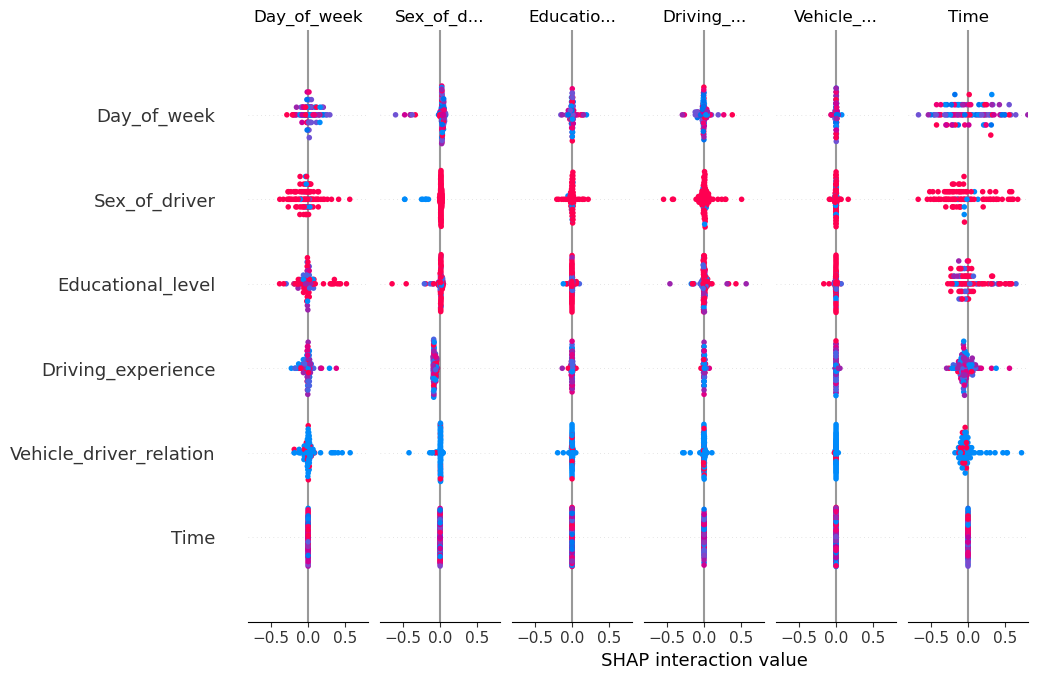

In [4]:
#------------------------------------------------
# ALL Below Cells Will Be Decision Tree Classifier
#------------------------------------------------

#------------------------------------------------
# SHAP
#------------------------------------------------

explainer_dt = shap.TreeExplainer(dt_clf);

# Take a smaller sample of X_test for faster SHAP calculations
sample_X_test = X_test.sample(100, random_state=42)  # Adjust sample size if needed

# Calculate SHAP values
shap_values_dt = explainer_dt.shap_values(sample_X_test)

# Display summary plot
print("SHAP Decision Tree Classifier")
figure = plt.figure()
shap.summary_plot(shap_values_dt, sample_X_test)

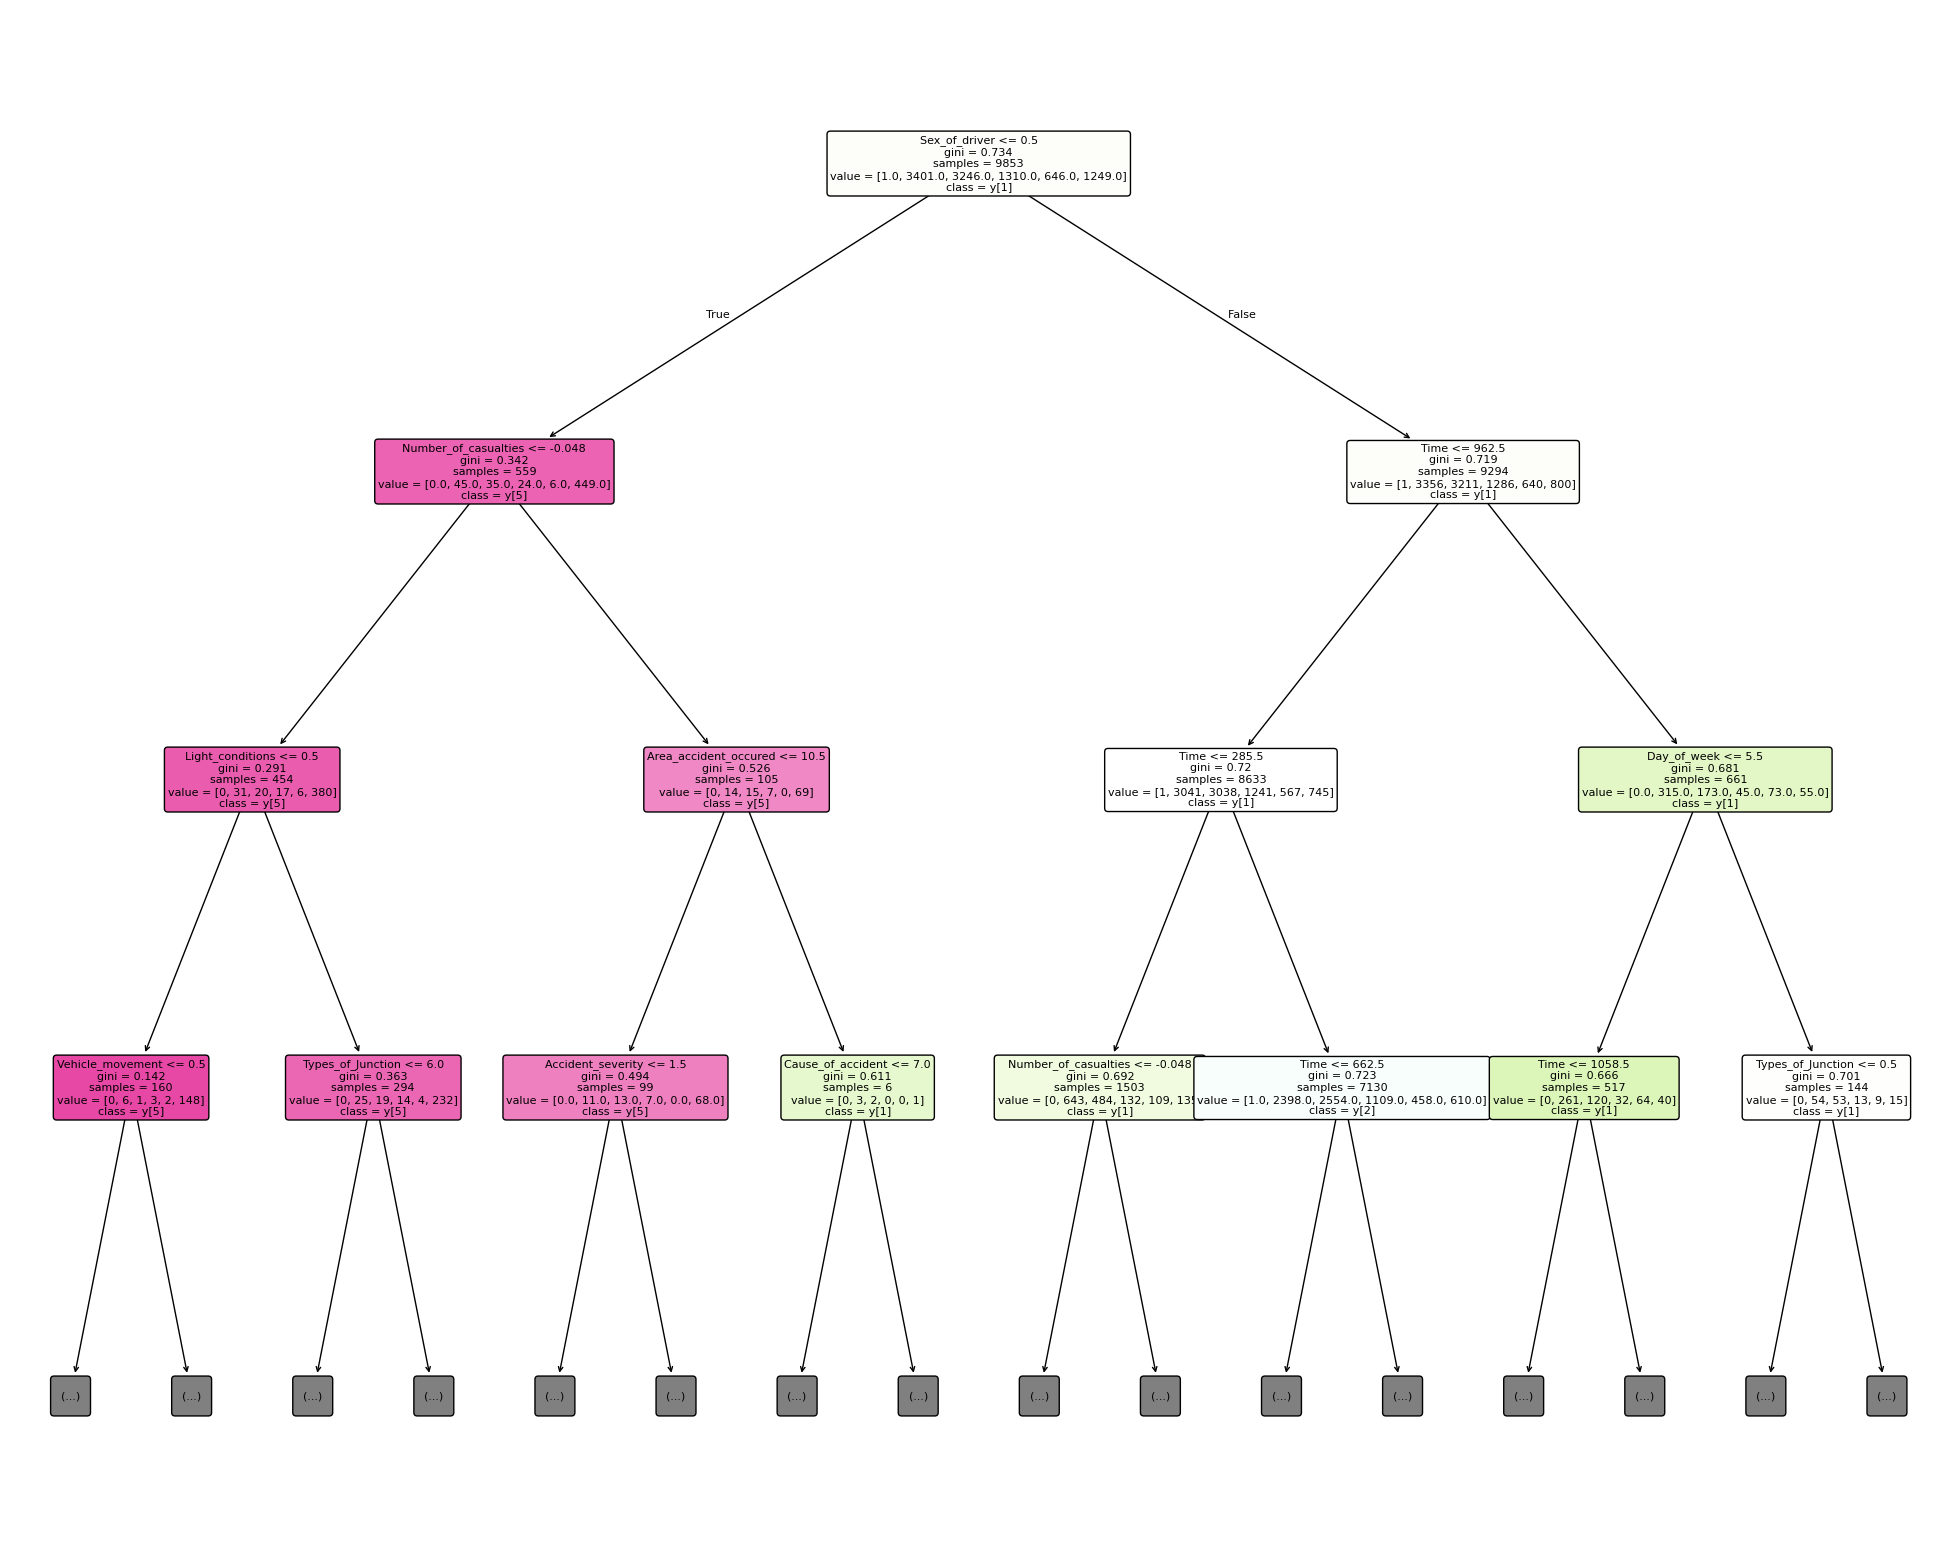

In [28]:
#------------------------------------------------
# Decision Tree Visualization
#------------------------------------------------

fig = plt.figure(figsize=(25, 20))
plot_tree(dt_clf, max_depth=3, filled=True, feature_names=X.columns, class_names=True, rounded=True, fontsize=8)
plt.show()

In [ ]:
#------------------------------------------------
# LIME
#------------------------------------------------

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Legitimate', 'Illegitimate'],
    mode='classification'
)

# Choose an instance to explain
instance_to_explain = X_test.iloc[0]

# Generate explanation for the chosen instance
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=dt_clf.predict_proba
)

# Display explanation
explanation.show_in_notebook()


In [ ]:
#------------------------------------------------
# PDP
#------------------------------------------------

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

for feature in X_train.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    display = PartialDependenceDisplay.from_estimator(
        dt_clf,                        # Model instance
        X_train,                       # Training data
        features=[feature],            # Feature to plot
        target=0,           
        kind="average",                # Use "average" for PDP, "individual" for ICE plot
        n_jobs=-1,                     # Use all processors for faster performance
        grid_resolution=20,            # Number of grid points
        ax=ax,
        subsample=1500                   # Randomly sample 50 instances from the dataset
    )
    
    # Add title and display
    display.figure_.suptitle(f"Partial Dependence Plot")
    plt.show()

In [ ]:
#------------------------------------------------
# ALL Below Cells Will Be Logistic Regression
#------------------------------------------------

#------------------------------------------------
# SHAP
#------------------------------------------------

explainer = shap.Explainer(lr_clf, X_train, feature_names=X_train.columns)

# Take a smaller sample of X_test for faster SHAP calculations
sample_X_test = X_test.sample(100, random_state=42)  # Adjust sample size if needed

# Calculate SHAP values
shap_values_lr = explainer_lr.shap_values(sample_X_test)

# Display summary plot
print("SHAP Decision Tree Classifier")
figure = plt.figure()
shap.summary_plot(shap_values_lr, sample_X_test)

In [ ]:
#------------------------------------------------
# LIME
#------------------------------------------------

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Legitimate', 'Illegitimate'],
    mode='classification'
)

# Choose an instance to explain
instance_to_explain = X_test.iloc[0]

# Generate explanation for the chosen instance
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=lr_clf.predict_proba
)

# Display explanation
explanation.show_in_notebook()


In [ ]:
#------------------------------------------------
# PDP
#------------------------------------------------

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

for feature in X_train.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    display = PartialDependenceDisplay.from_estimator(
        lr_clf,                        # Model instance
        X_train,                       # Training data
        features=[feature],            # Feature to plot
        target=0,           
        kind="average",                # Use "average" for PDP, "individual" for ICE plot
        n_jobs=-1,                     # Use all processors for faster performance
        grid_resolution=20,            # Number of grid points
        ax=ax,
        subsample=1500                   # Randomly sample 50 instances from the dataset
    )
    
    # Add title and display
    display.figure_.suptitle(f"Partial Dependence Plot")
    plt.show()